### Grism_calibrate
#### Create grism calibration files by comparing grism spectra with Jacoby reference spectra

RLM 23 June 2021

In [1]:
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import os,sys
import numpy as np
#import ccdproc as ccdp

from grism_calibrate_lib import grism_calibrate

deg = np.pi/180.

do_plot = True

In [2]:
fts_file = 'HD28696_8.fit'
im, hdr = getdata(fts_file, 0, header=True)
grism_filter = hdr['FILTER'][0]
star = hdr['OBJECT']
star = 'HD28696'
print('Analyzing image %s, grism filter %s' % (fts_file,grism_filter))

# Determine Jacoby reference file name, check for existence
ref_file = '%s-Jacoby-spec.csv' % star
if os.path.exists(ref_file):
    print('Found Jacoby reference image for star %s' % star)
else:
    print('Cannot find Jacoby reference file %s' % ref_file)

# Instantiate class

G = grism_calibrate(fts_file,ref_file)

image, star, utdate,telescope, instrument, fil = G.get_info()
print('%s:  %s   %s  %s' % (star,utdate,telescope,instrument))

Analyzing image HD28696_8.fit, grism filter 8
Found Jacoby reference image for star HD28696
:  2022-01-31 07:56:17   IRO-Gemini  SBIG Aluma AC4040


Select a subimage near image center to calcualte rotation angle

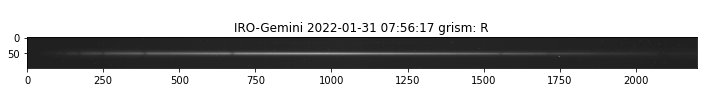

In [3]:
xoff = 0 ; yoff = -20
xw = 1100 ; yw = 50  # Adjust by hand

ys,xs = image.shape
xc = int(xs/2) + xoff ; yc = int(ys/2) + yoff
ymin = yc - yw; ymax = yc + yw
xmin = xc - xw; xmax = xc + xw
box = [xmin,xmax,ymin,ymax]

subim = image[ymin:ymax,xmin:xmax]
fig = G.plot_image(image=subim,figsize =(12,6),cmap='gray')

Calculate angle, create subimage using box, set width

In [6]:
ywidth = 50
angle,subim = G.rotate_image(box,ywidth)
print('Rotation = %.1f deg' % angle)

Rotation = 0.0 deg


Plot uncalibrated strip spectrum 

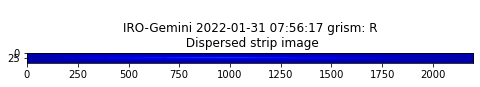

In [7]:
# Plot full image
fig = G.plot_strip()

In [8]:
G.calc_spectrum()

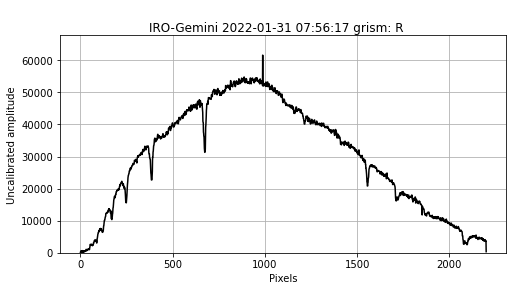

In [9]:
fig=G.plot_spectrum(uncalibrated = True, medavg =3)

Wavelength calibration: Find peaks, compare to Balmer lines to calculate pixel-> wavelength polynomial coeffs

Peaks:    [ 170  249  386  675 1556]
Reflines:  [397, 410.17, 434.05, 486.14, 656.3]


/var/folders/72/x005f_sn1nq047zkj8cd5ppw0000gn/T/ipykernel_44980/47924102.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


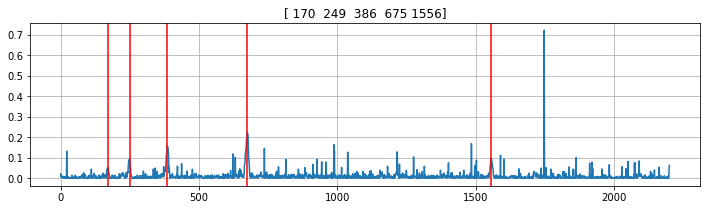

In [11]:
# Adjust manually
prominence = 0.05
peaks, fig = G.find_spectral_peaks(prominence=prominence, do_plot=True)
fig.show()

Halpha = [397, 410.17, 434.05, 486.14,656.3] # 397.0, 410.17, 
ref_lines = Halpha

# Enter pixel values of peaks that correspond to Balmer lines listed above
peaks = peaks
print ('Peaks:   ',peaks)
print('Reflines: ',ref_lines)

Find coefficients of quadratic fit pixel -> wavelength

In [12]:
f_wave,c = G.calc_wave(peaks,ref_lines)
wavelength_coefficients = c
print ('Wavelength calibration fit coefficients = %.2e,  %.3f,  %.2f' % (c[0],c[1],c[2]))

Wavelength calibration fit coefficients = 1.20e-05,  0.167,  368.13


Clip spectrum arrays to specified wavelength range to ensure it is within Jacoby range (350-744 nm)

In [13]:
# Clip spectrum 
wmin = 380; wmax = 710
wave,raw_spec = G.clip_spectrum(wmin, wmax)

Calibrate amplitudes

/var/folders/72/x005f_sn1nq047zkj8cd5ppw0000gn/T/ipykernel_44980/1083703675.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


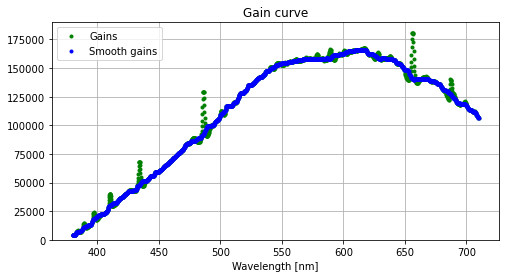

In [14]:
_,gain_curve,fig = G.calc_gain_curve(do_plot = True, do_poly=False, nsmooth=9,npoly=9)
fig.show()

Plot spectrum with wavelength calibrated

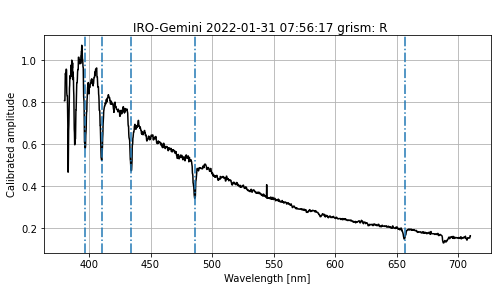

In [16]:
fig=G.plot_spectrum(uncalibrated = False, medavg =3,plot_balmer=True)

Write calibration information to a calibration file (NB doesn't need to exist)

In [17]:
from datetime import datetime
now = datetime.now()
date = now.strftime("%Y/%m/%d")

myfilter  = hdr['FILTER']
telescope = hdr['TELESCOP']
camera    = hdr['INSTRUME'][0:14]

image, star, utdate,telescope, instrument, fil

cal_file = 'grism_cal_%s_%s.csv' % (fil,date.replace('/','_'))

c1,c2,c3 = [float(x) for x in wavelength_coefficients]
hdr_line = 'Grism calibration created %s using %s, %s, Filter: %s\n' %(date,telescope, camera, myfilter)
cal_line = '%.2f, %.3e, %.3f, %.2f\n' % (float(angle),c1,c2,c3)
subim_box = '%i, %i, %i, %i\n' % (xmin,xmax,ymin,ymax)

with open(cal_file, 'w') as fh:
    fh.write(hdr_line)
    fh.write(cal_line)
    fh.write(subim_box)
    for j,w in enumerate(wave):
        fh.write('%.2f %.4f\n' % (w, gain_curve[j]))
print('Wrote calibration file %s' % cal_file)

Wrote calibration file grism_cal_8_2022_01_31.csv
